# Somerville Open Data Exploration
The city of Somerville has several open datasets that can be downloaded and analyzed.
Of interest, they perform a biannual (every 2 year) survey of resident happiness along with demographic data.
In addition, they have data regarding crime, crashes, and the number of pedestrians/cyclists observed.
I will use this notebook to explore these datasets. I would like to do at least some of the following:
* Explore the datasets for any interesting trends
* Create regression models that can reveal what factors are major contributors to happiness scores
* Cluster residents into different groups to identify what could enhance their living experience

In [1]:
# imports
import pandas as pd
import numpy as np
import scipy
import sklearn
import os
import matplotlib.pyplot as plt

In [2]:
# Loading in data
path2csv = 'C:/Users/kevjm/Documents/GitHub/SomervilleOpenDataExploration/data'
d = os.listdir(path2csv)

df_bike_ped_counts = pd.read_csv(path2csv + '/' + d[0])
df_crashes = pd.read_csv(path2csv + '/' + d[1])
df_crime = pd.read_csv(path2csv + '/' + d[2])
df_happiness = pd.read_csv(path2csv + '/' + d[3],low_memory=False)

The Somerville Happiness dataset (https://data.somervillema.gov/Health-Wellbeing/Somerville-Happiness-Survey-Responses/pfjr-vzaw/about_data) is a large dataframe where each row is a survey respondent. The respondent was asked a number of demographic and lifestyle questions and was also asked to rank their happiness on a scale of 1 - 5. A full description of the data can be found on the Somerville webiste and here is a small sampling of what we are working with.

In [3]:
df_happiness.head()

,ID,Year,Survey.Method,Survey.Language,Gender,Age,Age.mid,Race.Ethnicity,Housing.Status,Tenure,...,Green.Line.Extension.Satisfaction.5pt.num,Green.Line.Extension.Satisfaction.5pt.label,Bus.Bicycle.Lanes.Satisfaction.5pt.num,Bus.Bicycle.Lanes.Satisfaction.5pt.label,Bluebikes.Satisfaction.5pt.num,Bluebikes.Satisfaction.5pt.label,ACS.Year,ACS.Somerville.Median.Income,ACS.Somerville.Avg.Household.Size,Inflation.Adjustment
0,560,2011,Paper,NaN,Man,61 or older,61.0,White,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2011,64480,2.29,1.35
1,561,2011,Paper,NaN,Woman,26-30,28.0,White,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2011,64480,2.29,1.35
2,562,2011,Paper,NaN,Man,61 or older,61.0,White,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2011,64480,2.29,1.35
3,563,2011,Paper,NaN,Woman,61 or older,61.0,White,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2011,64480,2.29,1.35
4,564,2011,Paper,NaN,Man,26-30,28.0,White,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2011,64480,2.29,1.35


## Happiness Survey Exploration

#### Happiness Score by Demographics
There are many ways to divide these data, so I'd like to make a function that plots the distribution of happiness scores as a function of some other feature (e.g., year, age range, ward, etc.)

In [4]:
def plot_happiness_dist(df,groupby_var):
    """
    This function takes the dataframe that houses all happiness survey answers and 
    creates stacked bar plots based on the provided groupby_var.
    
    If one variable is provided, each stack of bar represent the proportion of 
    respondents who scored their happiness as 1, 2, 3, 4, or 5 for that given 
    variable.
    
    If, however, two variables are provided (e.g., [Ward, Year]), then a series of 
    subplots are made for all of the options for the first variable and then split 
    by the second wihtin stacked bars
    """
    my_colors = ['#b0b0b0','#758a9b','#ffd366','#f6a437','#ec7014']
    grouped_scores = (df.groupby(groupby_var)
                      ['Happiness.5pt.num']
                      .value_counts()
                     )
    
    if len(groupby_var) > 2:
        fig = plt.figure(figsize=(10,6))
        ax = fig.add_subplot(1,1,1)
        grouped_scores_norm = (grouped_scores.unstack()
                               .iloc[:,0:5]
                               .div(grouped_scores
                                    .unstack()
                                    .sum(axis=1),
                                    axis = 0)
                              )
        grouped_scores_norm.plot(ax = ax,
                                 kind = 'bar',
                                 stacked = True,
                                 color = my_colors,
                                 legend = False)
        ax.set_xlabel(f'{groupby_var}')
        ax.set_ylabel('Prop Respondents')
        ax.set_title(f'Happiness Score Across {groupby_var}')
    else:
        lvl1_vals = sorted(list(set(grouped_scores.index.get_level_values(0))))
        fig,axes = plt.subplots(1,len(lvl1_vals))
        c = 0
        for val in lvl1_vals:
            grouped_scores_sub = grouped_scores.xs(val)
            grouped_scores_sub_norm = (grouped_scores_sub.unstack()
                                       .iloc[:,0:5]
                                       .div(grouped_scores_sub
                                            .unstack()
                                            .sum(axis=1),
                                            axis = 0)
                                      )
            
            # plt.subplot(1,len(lvl1_vals),c+1)
            grouped_scores_sub_norm.plot(ax = axes[c], 
                                         kind = 'bar',
                                         stacked = True, 
                                         color = my_colors,
                                         legend = False)
            axes[c].set_xlabel(groupby_var[1])
            if c == 0:
                axes[c].set_ylabel('Prop Respondents')

            axes[c].set_title(f'{groupby_var[0]}: {val}')
            c += 1
        fig.set_figwidth(20)
    
    plt.show()

The function above will produce stacked bar plots that show the proportion of respondents that scored their happiness on a 1 - 5 scale (5 is best). If we pass one factor (e.g., year) we can see how the distribution of happiness scores changes across time. In the figures below, gray indicates the proportion of respondents who answered 1 and dark orange represents the proportion of respondents who answered 5.

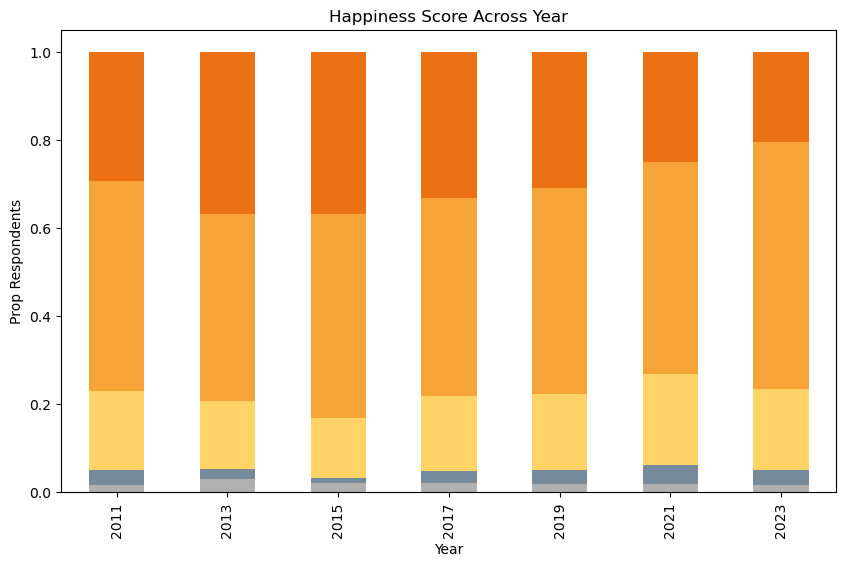

In [5]:
plot_happiness_dist(df_happiness,'Year')

Grouping over year may lose some nuance or subtleties in the data. Thus, the code above can take up to two factors to see how they interact. For instance, we can address whether happiness scores change across time uniformly throughout Somerville. Somerville is divided into 7 representational wards. Below we can pass a list of column names to look at how 

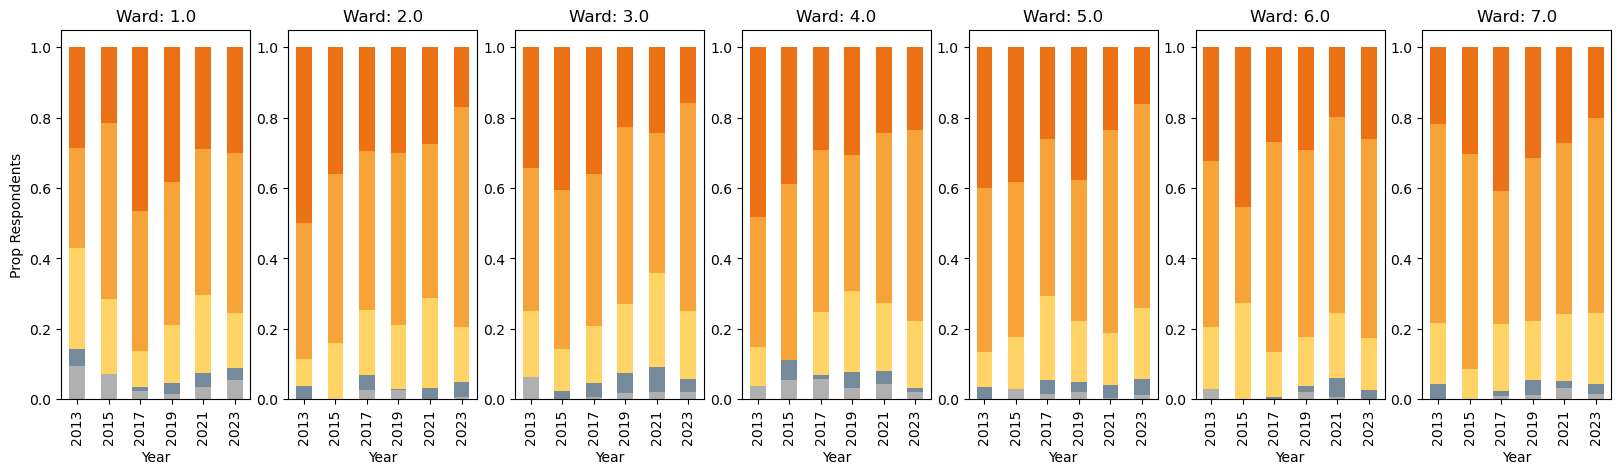

In [6]:
plot_happiness_dist(df_happiness,['Ward','Year'])

Looking at these plots one at a time shows that the majority of respondents score their happiness as 4 or 5 across all years and across all wards. Of particular note, Ward 7 residents in 2015 were very happy! To better understand how local trends influence happiness scores, we can incorporate additional data that is not covered in the survey.

#### Finding Relationships between Survey Factors
There are many questions within the survey each of which may correlate with a happiness score. First, let's define a function that plots a given factor against the average happiness score for each value within the requested factor.

In [119]:
def plot_mn_happiness(df,col_feature,col_score = 'Happiness.5pt.num',sem_flag = False):
    df_grp = (df[[col_feature,col_score]]
          .groupby([col_feature])
          .agg(['mean','median','std','count'])
          .reset_index()
         )
    fig, ax = plt.subplots()
    
    if sem_flag:
        plt.errorbar(df_grp[col_feature],df_grp[col_score,'mean'],
             df_grp[col_score,'std'] / (df_grp[col_score,'count'])**0.5,
             color = 'k')
    else:
        plt.errorbar(df_grp[col_feature],df_grp[col_score,'mean'],
             df_grp[col_score,'std'],
             color = 'k')

    ax.set_ylim(0,5.5)
    ax.set_xlabel(col_feature)

    if col_score == 'Happiness.5pt.num':
        ax.set_ylabel('Mean Happiness Score')
    else:
        ax.set_ylabel(f'Mean ({col_score})')
    

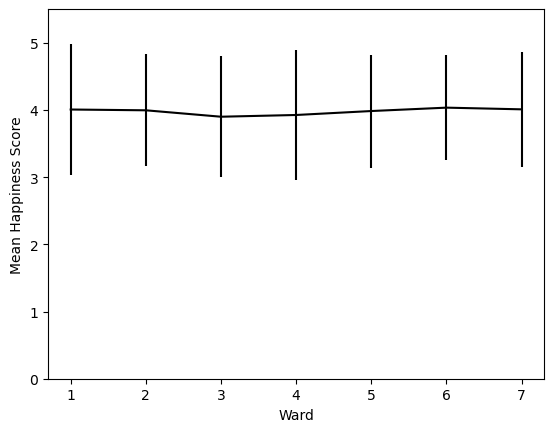

In [133]:
plot_mn_happiness(df_happiness,'Ward')

This function is good to look at survey responses one-at-a-time, but I would like to have a higher throughput data visualization. Additionally, while this survey has a lot of information, there are some more data we can add. First, I will add more data to the existing survey data and then iterate across a range of factors to visualize which seem to be related to average happiness scores.

### Incorporating Other Data into Happiness Survey

#### Crime and Crashes
The Somerville Police Department maintains a listing of reported crimes and crashes. We can use these numbers to identify whether the prevalence of either (or both) influence's a resident's happiness in that year

#### Pedestrians and Cyclists
As a cyclist, my happiness is definitely related to how easy it is to bike around Somerville and it brings me joy to see other cyclists. Somerville has an ongoing survey where volunteers count the number of pedestrians and cyclists at known locations throughout the city. Here, I will create a metric that provides a pedestrian-to-cyclist score to indicate the prevalence of cyclists throughout the city.

#### COVID Cases
Starting in 2020, the COVID-19 pandemic greatly shifted how Somerville residents lived and could influence their happiness. While Somerville does not have an existing database for COVID prevalence, the neighboring town of Cambridge, MA has kept such a database public for posterity.

### Visualizing Multiple Features

### Building a Regression Model
Now that we have a sense of how various features influence the average happiness score, I would like to figure out what features are most strongly related to the happiness score. For this, I will turn to a linear regression model. This model assumes that some output (here, a respondent's happiness score) can be predicted by a linear sum of a set of features (here, the survey responses and additional data we added above). To build the model, we must first process the data so that it can be used in the training

#### Processing data: Filling in Missing Values
In a few instances, there are no answers for a given question. This could be because the repsondent did not answer or that the question was not included in that year's survey. Nevertheless, we want to fill in the missing value. In the case that the person left the question unanswered, I will impute the most common value from other respondents from the same Ward (alternatively, we could use some other demographic like age/gender/race/etc.). For instances where the question was not present on that year's survey, I will impute with the cross-year mean value.

#### Processing data: One-Hot Encoding
Several of the survey questions are categorical in nature (e.g., 